# Schelling's Model of Segregation

Consider a version of the Schelling's segregation model implemented in the following way:
1. $N$ agens ($\{n_1, n_2, \dots, n_N\}$) are generated ($N^b$ blue, $N^r  = N - N^b$ red).
2. Each individaul is initially placed (uniformly) at random on a $100 \times 100$ square lattice.
3. Start with individual $n_1$ (who has type $t \in (b, r)$) then proceed with the algorith:
    1. Take individaul $n_i$ who has type $t$. If at least $j_t$ of its $m_t$ closest neighbors are of the same type, move on to next individual.
    2. If fewer neighbors than $j_t$ are of the type, move the individual to a randomly selected new empty location. Ten move on to next individaul.
    3. Continue this process untill no individuals remain who wish to move.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display
import random
from tqdm.notebook import tqdm

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 6]

In [3]:
# Class labels
EMPTY = 0
BLUE = 1
RED = 2

To represent the square lattice we will create a `PeriodicLattice` class, which will be a subclass of `numpy.ndarray`. It will behave exactly like standard matrix, but will overwrite the `__getitem__` and `__setitem__` in a way than the boundaries are periodic. It also implements the `neighbours` method, which returns a list of neighbours of a given element (respecting the periodic boundary conditions).

*(Subclassing from `numpy.ndarray` is based on [numpy documentation](https://docs.scipy.org/doc/numpy/user/basics.subclassing.html#new-from-template) and [Alexanders McFarlane answer](https://stackoverflow.com/questions/38066785/np-ndarray-with-periodic-boundary-conditions) to StackOverflow question.)*

In [5]:
class PeriodicLattice(np.ndarray):
    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj
    
#     def __array_finalize__(self, obj):
#         if obj is None: return
# #         self.info = getattr(obj, 'info', None)

    def __getitem__(self, index):
        index = self._wrap_index(index)
        return super(PeriodicLattice, self).__getitem__(index)

    def __setitem__(self, index, value):
        index = self._wrap_index(index)
        return super(PeriodicLattice, self).__setitem__(index, value)
    
    def _wrap_index(self, index):
        if type(index) == int:
            return (index % self.shape[0] + self.shape[0]) % self.shape[0]
        if (type(index) == slice 
            or any(type(i) in (list, slice) for i in index)):
            return index
        if len(index) != len(self.shape):
            return index
        if len(index) == len(self.shape):
            mod_index = tuple((i % shape + shape) % shape for i, shape in zip(index, self.shape))
            return mod_index
        
    def neighbours(self, index, radius=1):
        xc, yc = index  # Center
        indices = [self._wrap_index((x, y)) for x in range(xc - radius, xc + radius + 1) 
                   for y in range(yc - radius, yc + radius + 1) 
                   if (x, y) != (xc, yc)]
        # We count only distinct neighbours
        indices = list(dict.fromkeys(indices))  # As of python 3.7 dict.fromkeys() preserves order
        xs = [x for x, y in indices]
        ys = [y for x, y in indices]
        return np.array(self[xs, ys])

To generate better looking images we also define a `display_lattice` function:

In [6]:
def display_lattice(matrix, fig=None, ax=None, colorbar=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    image = ax.matshow(matrix, 
                       interpolation="nearest", 
                       aspect="equal",
                       extent=[0, matrix.shape[1], 0, matrix.shape[0]])
    ax.set_xticks(np.arange(matrix.shape[1]), minor='true')
    ax.set_yticks(np.arange(matrix.shape[0]), minor='true')
    if all(s < 50 for s in matrix.shape):
        plt.grid(alpha=1, color='white', which='minor')
    if colorbar:
        plt.colorbar(image, ax=ax)

Example usage of `PeriodicLattice` and `display_lattice` is shown below:

In [7]:
lattice = PeriodicLattice(np.arange(9).reshape(3, 3))
lattice

PeriodicLattice([[0, 1, 2],
                 [3, 4, 5],
                 [6, 7, 8]])

In [8]:
lattice[1, 3]  # Periodic indexing

3

In [9]:
lattice.neighbours((0, 0))  # Neighbours with periodic indexing 

array([8, 6, 7, 2, 1, 5, 3, 4])

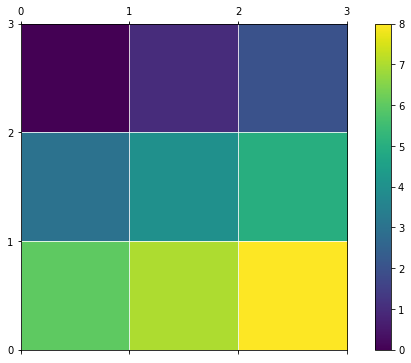

In [10]:
display_lattice(lattice)  # Plotting

## Exercise 1
Run a baseline model with two populations of size $250$ each. For each group assume $m_t = 8$ and $j_t = 0.5$ (work with periodic boundary conditions to treat the agents on the edges on the same footing).

**Solution:** 

We first define the model parameters:

In [11]:
SHAPE = (100, 100)
N_BLUE = 250
N_RED = 250
M = 1  # This parameters is changed to reflect the "radius" around cell.
J = 0.5

Then we define an empty lattice

In [12]:
lattice = PeriodicLattice(np.full(SHAPE, EMPTY))

We will also need a `fill_empty` function, which will fill empty places with given value.

In [13]:
def fill_empty(matrix, n, value, empty_val=EMPTY):
    """Fills n empty places in given matrix with given value."""
    mat_copy = matrix.copy()
    empty_indices = [(x, y) for (x, y), value in np.ndenumerate(matrix) if value == empty_val]
    try:
        random_indices = np.array(random.sample(empty_indices, n))
    except ValueError as e:
#         raise ValueError("Not enough space to fill.") from e
        random_indices = np.array(empty_indices)  # Fill all possible places
    if len(random_indices) > 0:
        mat_copy[random_indices[:, 0], random_indices[:, 1]] = value
    return mat_copy

Now we can fill the lattice with both populations

In [14]:
lattice = fill_empty(lattice, N_BLUE, BLUE)
lattice = fill_empty(lattice, N_RED, RED)

And display it

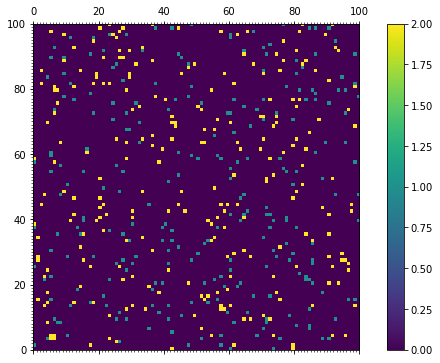

In [15]:
display_lattice(lattice)

Now we define the `update` function which will run single iteration of the simulation. It finds all cells that are "unhappy" with their neighbours and then moves them to random unoccupied place.

In [16]:
def update(matrix, neighbourhood_dist=1, satisfaction_lvl=0.5):
    unhappy = []
    num_unhappy_blues = 0
    num_unhappy_reds = 0
    for index, value in np.ndenumerate(matrix):
        if matrix[index] != EMPTY:
            type_ = matrix[index]
            neighbours = [n for n in matrix.neighbours(index, radius=neighbourhood_dist) if n != EMPTY]
            same_neighbours = [n for n in neighbours if n == type_]
            if len(neighbours) == 0 or len(same_neighbours) / len(neighbours) <= satisfaction_lvl:
                unhappy.append(index)
                if value == BLUE:
                    num_unhappy_blues += 1
                elif value == RED:
                    num_unhappy_reds += 1

    matrix = fill_empty(matrix, num_unhappy_blues, BLUE)  # Moving blues
    matrix = fill_empty(matrix, num_unhappy_reds, RED)  # Moving reds
    unhappy = np.array(unhappy)
    if len(unhappy) > 0:
        matrix[unhappy[:, 0], unhappy[:, 1]] = EMPTY  # Emptying previously occupied spaces
    return matrix, unhappy

### Animation
To better visualize the simulation we will create an interactive animation.

We will need a list of frames

In [17]:
frames = []

We append the initial lattice to the `frames`

In [18]:
frames.append(lattice)

We run the animation capturing each iteration and appending it to the `frames`

In [19]:
while True:
    lattice, unhappy = update(lattice, neighbourhood_dist=M, satisfaction_lvl=0.5)
    frames.append(lattice)
    if len(unhappy) == 0:  # If there are no more unhappy cells
        break

We now have to predefine an matplotlib's `image` object, which we will be updated with each frame.

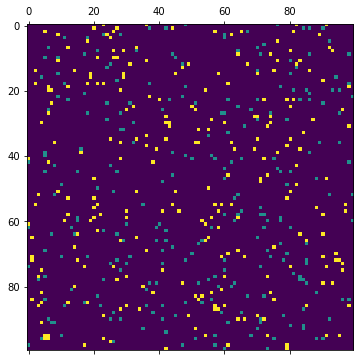

In [20]:
fig, ax = plt.subplots()
image = ax.matshow(frames[0])

We also have to define an `update_animation` function, which will be called by the animation.

In [21]:
frame_counter = 0
def update_animation(frame):
    global frame_counter
    image.set_array(frames[frame_counter])
    frame_counter += 1
    frame_counter = frame_counter % len(frames)

And now we simply run the animation and convert it to a javascipt widget.

In [22]:
anim = matplotlib.animation.FuncAnimation(fig, update_animation, frames=len(frames), 
                                          interval=250, repeat_delay=1000)

In [23]:
IPython.display.HTML(anim.to_jshtml())

## Exercise 2
Plot the initial and final distributions (for single runs). Run your program several times to see how stable the results are.

We will wrap the whole simulation into a single function

In [24]:
def simulation(lattice, neighbourhood_dist=1, satisfaction_lvl=0.5):
    iteration = 0
    while True:
        lattice, unhappy = update(lattice, neighbourhood_dist, satisfaction_lvl)
        iteration += 1
        if len(unhappy) == 0:  # If there are no more unhappy cells
            break
    return lattice, iteration

Now we can run the simulation 6 times for the same initial lattice:

In [25]:
SHAPE = (100, 100)
N_BLUE = 250
N_RED = 250
M = 1  # This parameters is changed to reflect the "radius" around cell.
J = 0.5

In [26]:
initial_lattice = PeriodicLattice(np.full(SHAPE, EMPTY))
initial_lattice = fill_empty(initial_lattice, N_BLUE, BLUE)
initial_lattice = fill_empty(initial_lattice, N_RED, RED)

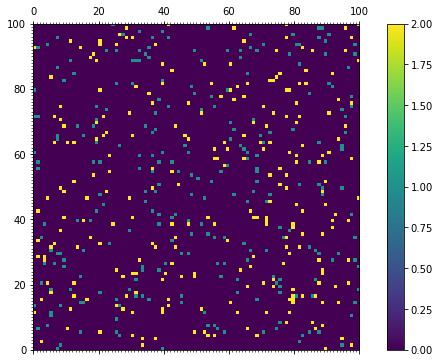

In [42]:
display_lattice(initial_lattice)

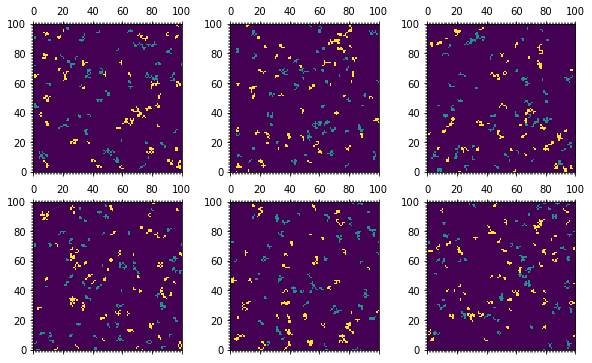

In [27]:
fig, axs = plt.subplots(2, 3)
for ax in tqdm(axs.flatten()):
    final_lattice, *_ = simulation(initial_lattice, M, J)
    display_lattice(final_lattice, fig, ax, False)

## Exercise 3
Plot the number of iterations as a function of population size (changing from 250 to 4000 for each group).

We define the ranges for populations:

In [28]:
n_agents = np.arange(250, 4000, 50)

In [29]:
empty_lattice = PeriodicLattice(np.full(SHAPE, EMPTY))
n_iterations = []
for n in tqdm(n_agents):
    lattice = fill_empty(empty_lattice, n, BLUE)
    lattice = fill_empty(lattice, n, RED)
    *_, iterations = simulation(lattice, M, J)
    n_iterations.append(iterations)

And plot the results

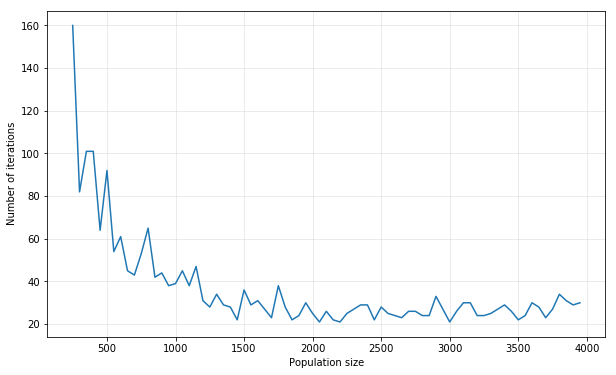

In [30]:
plt.plot(n_agents, n_iterations)
plt.xlabel('Population size')
plt.ylabel('Number of iterations')
plt.grid(alpha=0.3)
plt.show()

## Exercise 4
Plot the segregation index as a function of $j_t$ (changing from 0.1 to 0.9)

First we need to implement `segregation_index` function which will calculate it for given lattice

In [31]:
def segregation_index(matrix, neighbourhood_dist=1):
    segregation_indices = []
    for index, value in np.ndenumerate(matrix):
        if value != EMPTY:
            neighbours = [n for n in matrix.neighbours(index, radius=neighbourhood_dist) if n != EMPTY]
            same_neighbours = [n for n in neighbours if n == value]
            try:
                segregation_indices.append(len(same_neighbours) / len(neighbours))
            except ZeroDivisionError:
                segregation_indices.append(0)
    return np.array(segregation_indices).mean()

Then we define the range for $j_t$, run the simulation for each one and calculate the segregation index of the final distribution

In [52]:
jts = np.arange(0.1, 0.7, 0.04)  # Going to 0.9 takes definitely too much time and the curve is already flat

In [101]:
N_MONTE_CARLO = 30  # Number of Monte Carlo simulations for averaging results

lattice = PeriodicLattice(np.full(SHAPE, EMPTY))
lattice = fill_empty(lattice, N_BLUE, BLUE)
lattice = fill_empty(lattice, N_RED, RED)
segregation_indices = []
for jt in tqdm(jts):
    partial_results = []
    for i in range(N_MONTE_CARLO):
        final_lattice, *_ = simulation(lattice, M, satisfaction_lvl=jt)
        partial_results.append(segregation_index(final_lattice))
    segregation_indices.append(np.array(partial_results))

And plot the results

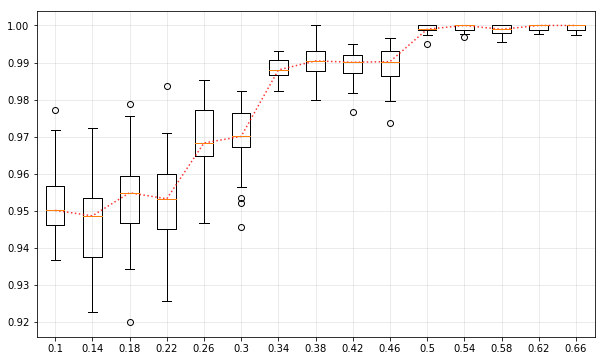

In [106]:
plt.boxplot(segregation_indices)
plt.plot(np.arange(1, len(segregation_indices) + 1),
         [np.median(partial) for partial in segregation_indices], 
         color='red', linestyle=':', alpha=0.8)
plt.xticks(ticks=np.arange(1, len(segregation_indices) + 1), 
           labels=[np.round(j, 2) for j in jts])
plt.grid(alpha=0.3)
plt.show()

## Exercise 5
Plot the segregation index as a function of $m_t$ (= 8, 24, 48, 80 and 120)

We proceed similary like in the previous exercise, but we define the range for the $m_t$

In [35]:
mts = np.array([1, 2, 3, 4, 5])  # We define the "radius" of the neighbours square

In [36]:
lattice = PeriodicLattice(np.full(SHAPE, EMPTY))
lattice = fill_empty(lattice, N_BLUE, BLUE)
lattice = fill_empty(lattice, N_RED, RED)
segregation_indices = []
for mt in tqdm(mts):
    final_lattice, *_ = simulation(lattice, mt, J)
    segregation_indices.append(segregation_index(final_lattice, mt))

And we plot the results

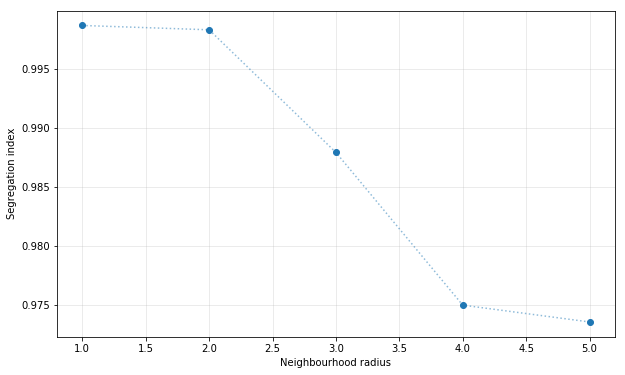

In [37]:
plt.plot(mts, segregation_indices, ':', color='tab:blue', alpha=0.5)
plt.plot(mts, segregation_indices, 'o', color='tab:blue')
plt.xlabel('Neighbourhood radius')
plt.ylabel('Segregation index')
plt.grid(alpha=0.3)
plt.show()

## Exercise 6
Comming back to the baseline simulation, see what happens if $j_r = 6/8$ and $j_b = 3/8$?

We will create the same lattice as in the baseline simulation

In [38]:
lattice = PeriodicLattice(np.full(SHAPE, EMPTY))
lattice = fill_empty(lattice, N_BLUE, BLUE)
lattice = fill_empty(lattice, N_RED, RED)

We will have to change the `update` function and make it that different satisfaction levels for each group could be provided.

In [39]:
def update2(matrix, neighbourhood_dist=1, satisfaction_lvl_r=0.5, satisfaction_lvl_b=0.5):
    unhappy = []
    num_unhappy_blues = 0
    num_unhappy_reds = 0
    for index, value in np.ndenumerate(matrix):
        if matrix[index] != EMPTY:
            type_ = matrix[index]
            neighbours = [n for n in matrix.neighbours(index, radius=neighbourhood_dist) if n != EMPTY]
            same_neighbours = [n for n in neighbours if n == type_]
            if type_ == RED and (len(neighbours) == 0 or len(same_neighbours) / len(neighbours) <= satisfaction_lvl_r):
                unhappy.append(index)
                num_unhappy_reds += 1
            elif type_ == BLUE and (len(neighbours) == 0 or len(same_neighbours) / len(neighbours) <= satisfaction_lvl_b):
                unhappy.append(index)
                num_unhappy_blues += 1
    matrix = fill_empty(matrix, num_unhappy_blues, BLUE)  # Moving blues
    matrix = fill_empty(matrix, num_unhappy_reds, RED)  # Moving reds
    unhappy = np.array(unhappy)
    if len(unhappy) > 0:
        matrix[unhappy[:, 0], unhappy[:, 1]] = EMPTY  # Emptying previously occupied spaces
    return matrix, unhappy

Then we can simply repeat the creation of interactive animation for a model with those parameters

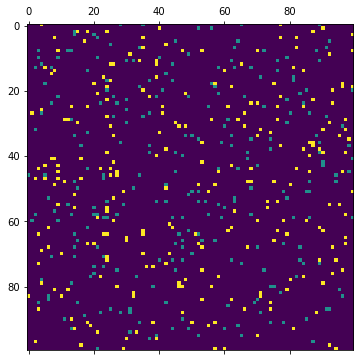

In [40]:
frames = []
frames.append(lattice)

# Simulation with appending frames
while True:
    lattice, unhappy = update2(lattice, M, 6 / 8, 3 / 8)
    frames.append(lattice)
    if len(unhappy) == 0:  # If there are no more unhappy cells
        break
        
fig, ax = plt.subplots()
image = ax.matshow(frames[0])

In [41]:
frame_counter = 0
def update_animation(frame):
    global frame_counter
    image.set_array(frames[frame_counter])
    frame_counter += 1
    frame_counter = frame_counter % len(frames)

anim = matplotlib.animation.FuncAnimation(fig, update_animation, frames=len(frames), 
                                          interval=250, repeat_delay=1000)

IPython.display.HTML(anim.to_jshtml())

As we can clearly see the **red cells are much more picky about their place and are searching longer for neighbourhood good enough**.